In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Window size=5

Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5029
SVM (RBF Kernel) Average Accuracy: 0.5525
Random Forest Average Accuracy: 0.7691
AdaBoost Average Accuracy: 0.1462
Extra Trees Average Accuracy: 0.7748

Best performing model: Extra Trees with Average Accuracy: 0.7748

Test Accuracy of the best model (Extra Trees): 0.8040


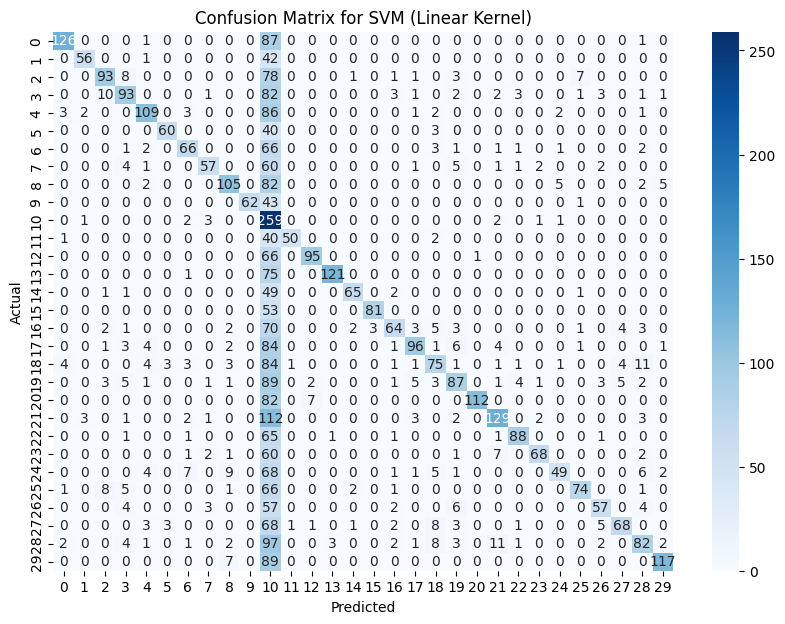

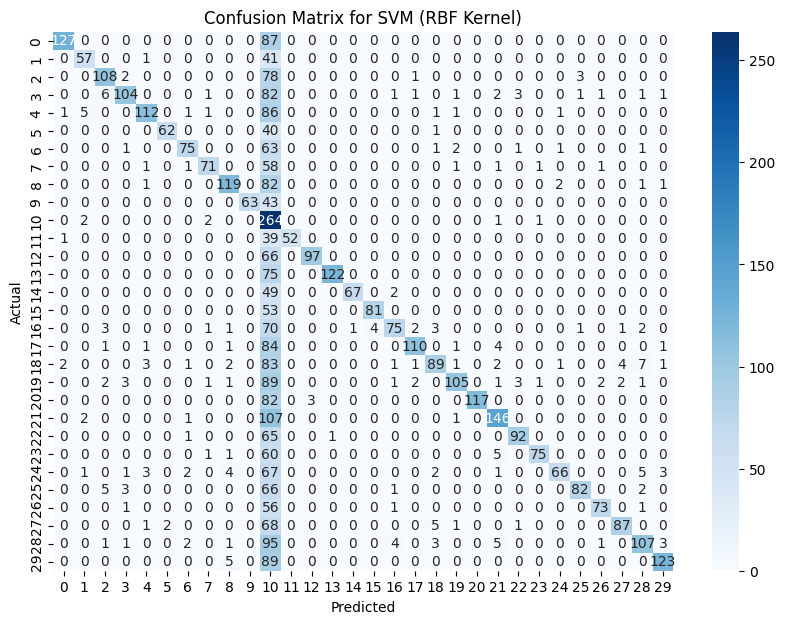

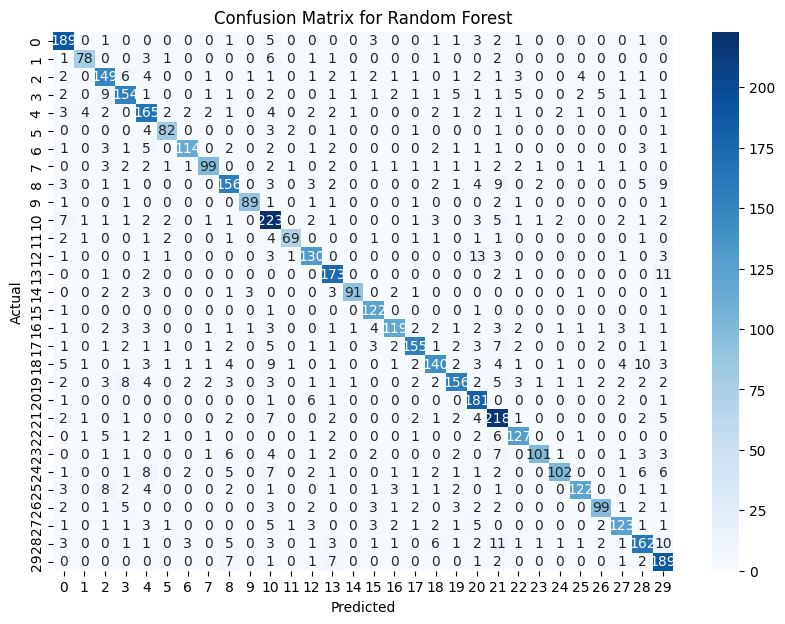

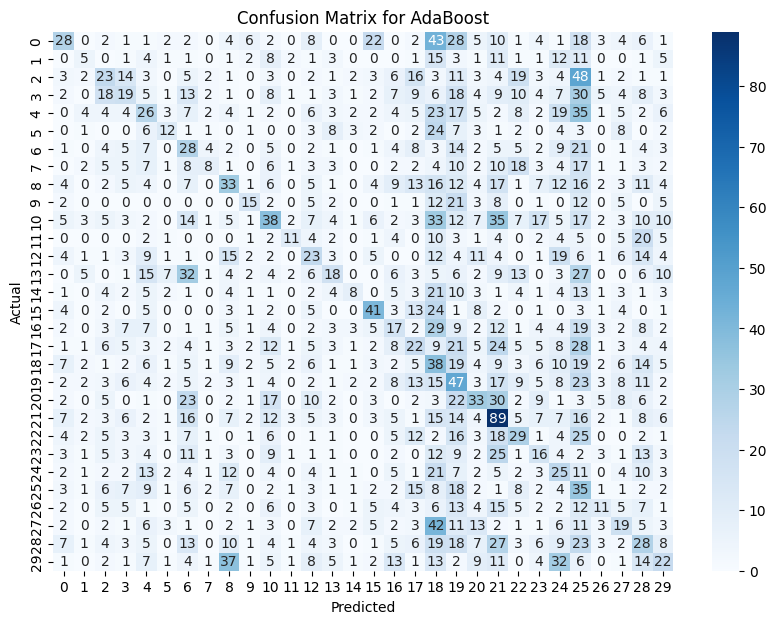

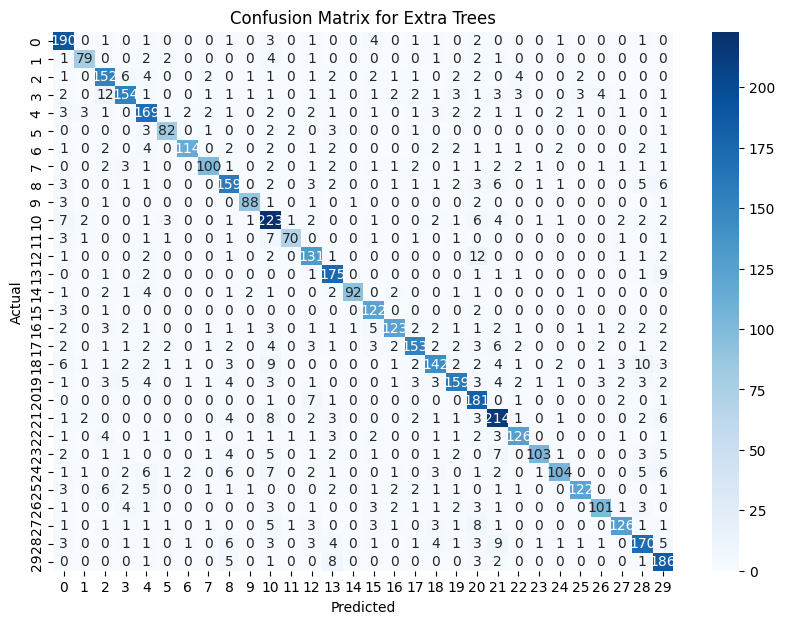


Confusion Matrix for Extra Trees:
[[220   0   1   0   0   2   0   0   2   0   4   1   3   0   0   1   0   0
    2   1   2   2   1   0   0   0   0   2   1   0]
 [  1  99   1   1   2   0   0   0   0   0   2   0   0   0   0   0   0   0
    3   0   0   0   3   0   1   0   0   0   1   0]
 [  2   1 198   9   4   3   0   2   1   0   2   2   1   7   1   9   0   0
    0   0   0   0   3   0   1   3   0   0   1   4]
 [  0   1  12 207   4   0   0   2   0   0   2   0   0   0   1   2   1   2
    3  14   1   6   7   1   1   4   0   2   1   4]
 [  5   1   3   2 229   4   1   1   2   0   5   1   1   5   1   0   1   0
    5   3   1   1   4   0   2   0   0   1   1   1]
 [  0   1   0   0   5 107   0   1   0   0   3   1   1   7   0   0   0   1
    0   0   2   0   0   0   1   0   0   0   0   0]
 [  2   0   1   1   3   1 139   0   1   0   2   0   4   0   1   0   0   1
    1   2   5   0   2   0   3   0   0   0   1   2]
 [  0   0   5   3   1   3   1 155   2   0   1   1   4   1   0   1   3   2
    0   1   0   

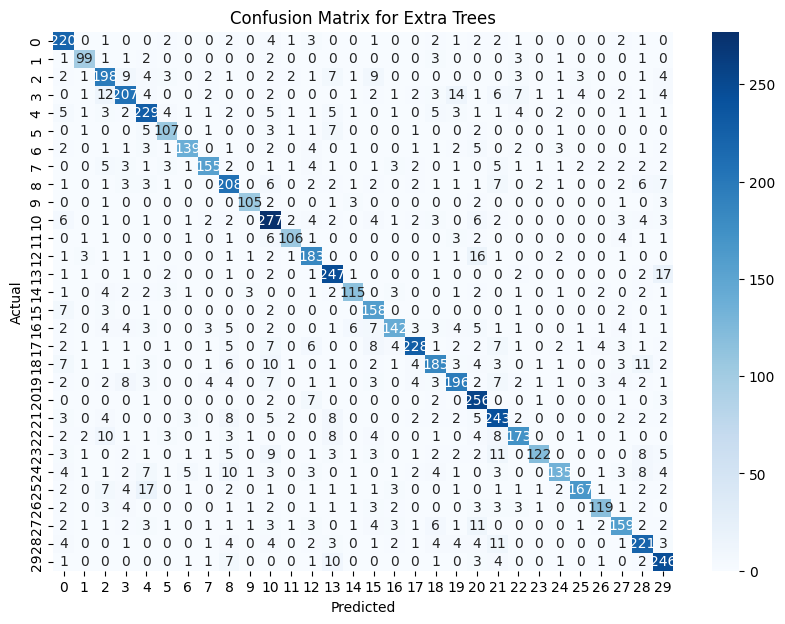

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/cooking_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=5):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Window size=1

Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5153
SVM (RBF Kernel) Average Accuracy: 0.6005
Random Forest Average Accuracy: 0.8578
AdaBoost Average Accuracy: 0.1791
Extra Trees Average Accuracy: 0.8678

Best performing model: Extra Trees with Average Accuracy: 0.8678

Test Accuracy of the best model (Extra Trees): 0.9050


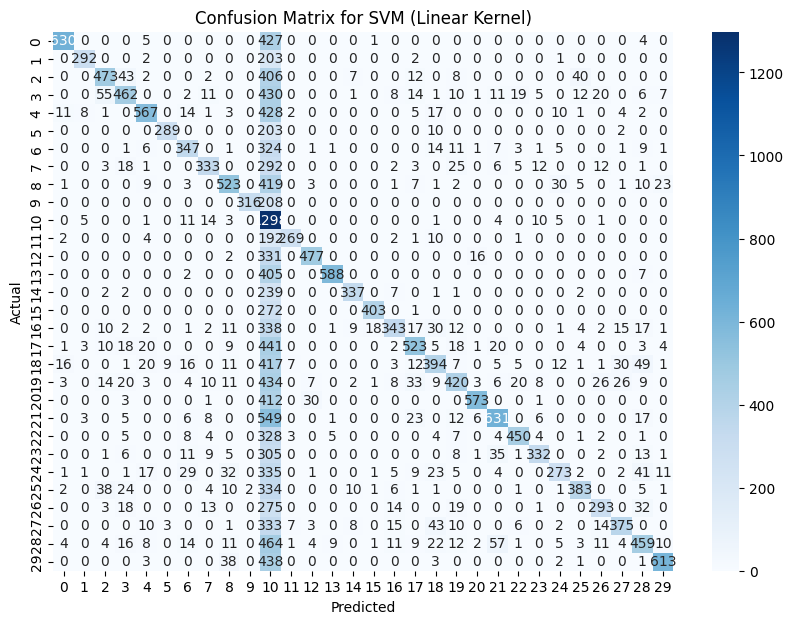

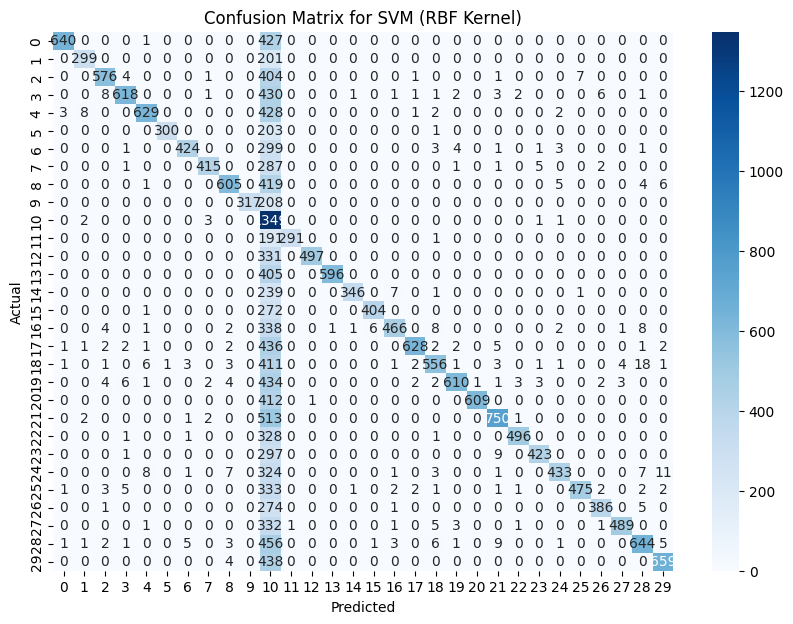

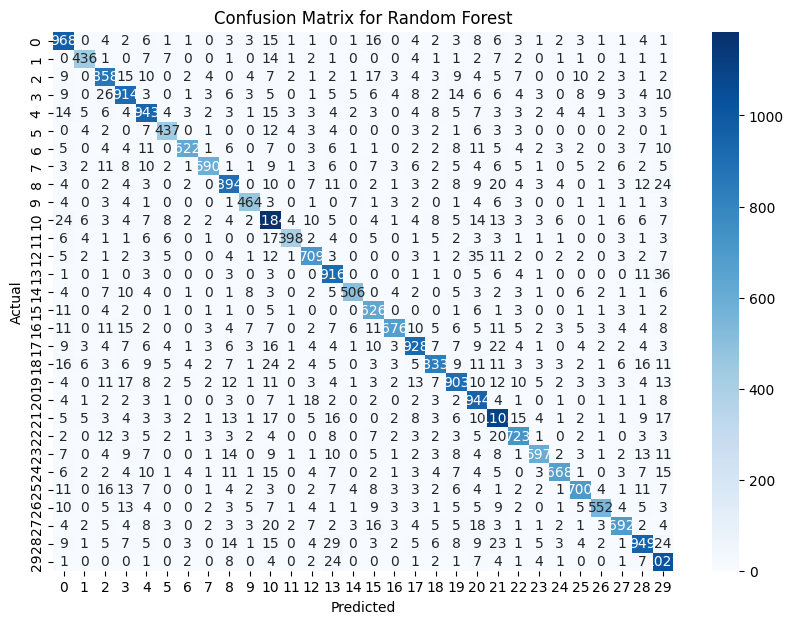

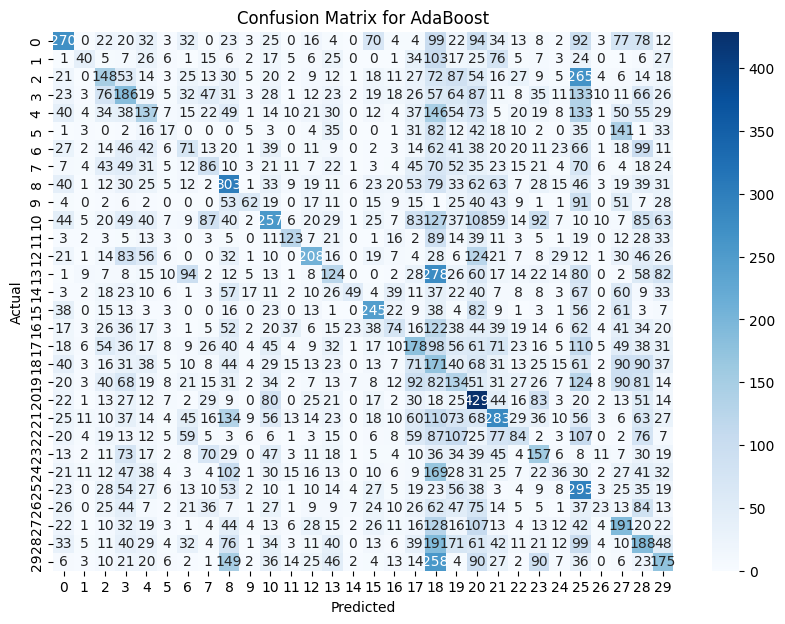

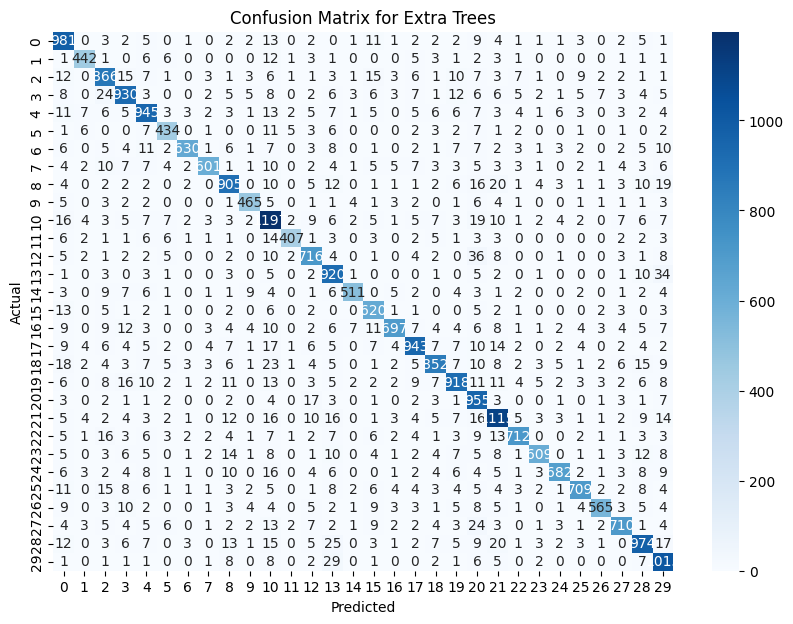


Confusion Matrix for Extra Trees:
[[1227    0    2    2    4    3    0    2    2    4    9    0    3    2
     1   10    1    3    2    2    8    5    1    0    3    2    0    7
     0    4]
 [   0  527    1    2    3    3    0    1    0    0    9    1    3    6
     0    1    0    4    2    1    3    5    4    0    1    0    1    0
     0    1]
 [  12    0 1097    6   10    1    1    2    2    1    4    3    0    0
     0   21    3    5    2    2    6    3   11    0    0    9    3    1
     2    1]
 [   7    0   18 1124    8    0    0    2    6    3    4    0    6   13
     2    7    2    5    3   12    8    6    6    2    1    6    3    3
     2    6]
 [   7    5    9    1 1201    8    6    2    6    2   13    2    6    7
     6    0    1    4    3    7   16    3    5    1    9    2    0    6
     1    2]
 [   1    5    0    0    2  638    1    1    2    0   20    1    1    2
     0    0    0    3    2    1    6    5    0    0    0    4    0    2
     0    3]
 [   4    0    2    2  

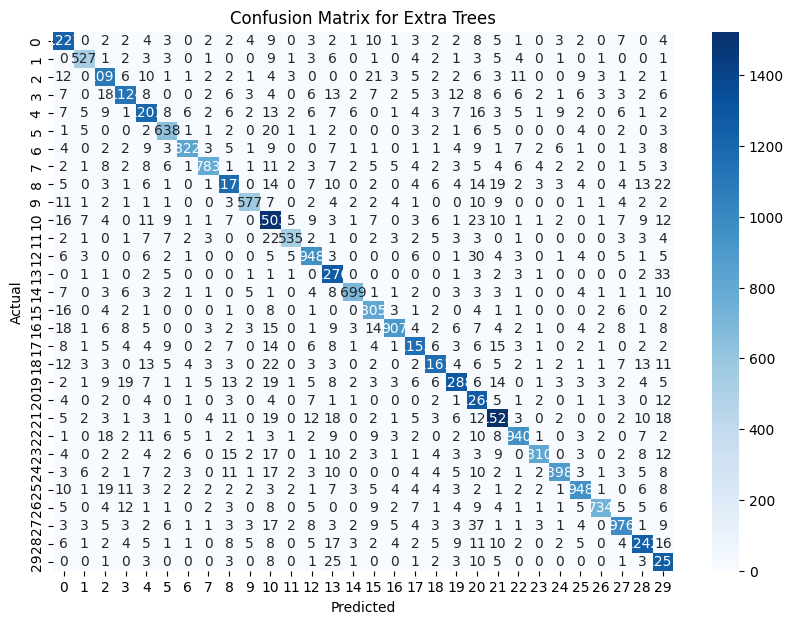

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/cooking_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=1):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Window size=3

Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.5069
SVM (RBF Kernel) Average Accuracy: 0.5708
Random Forest Average Accuracy: 0.7981
AdaBoost Average Accuracy: 0.1501
Extra Trees Average Accuracy: 0.8074

Best performing model: Extra Trees with Average Accuracy: 0.8074

Test Accuracy of the best model (Extra Trees): 0.8338


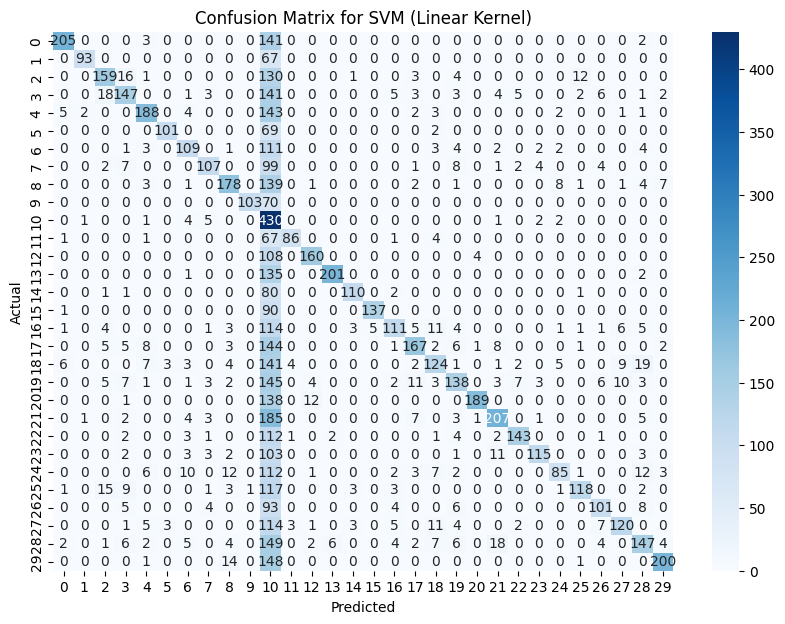

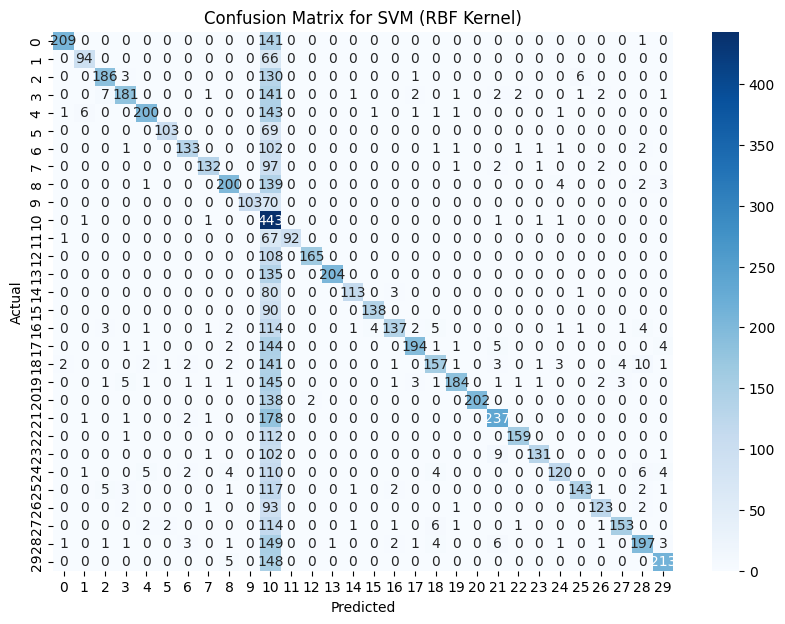

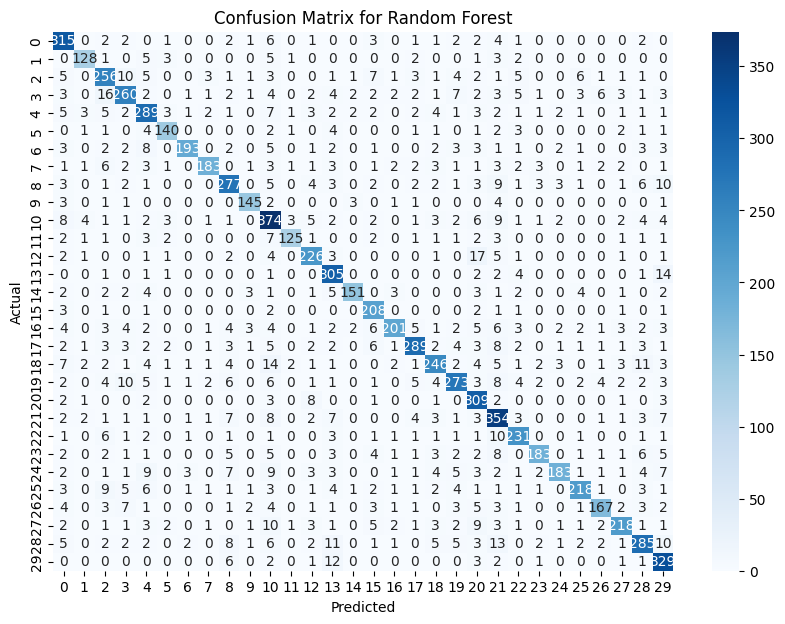

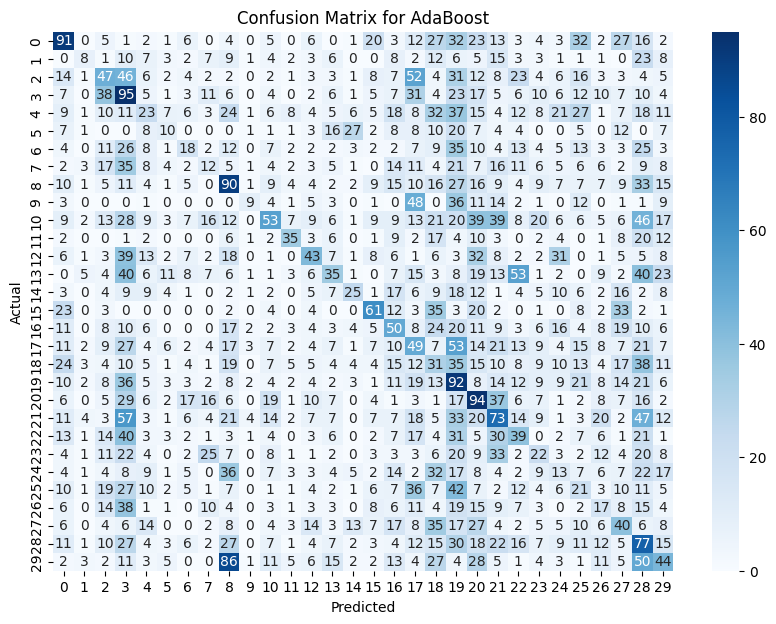

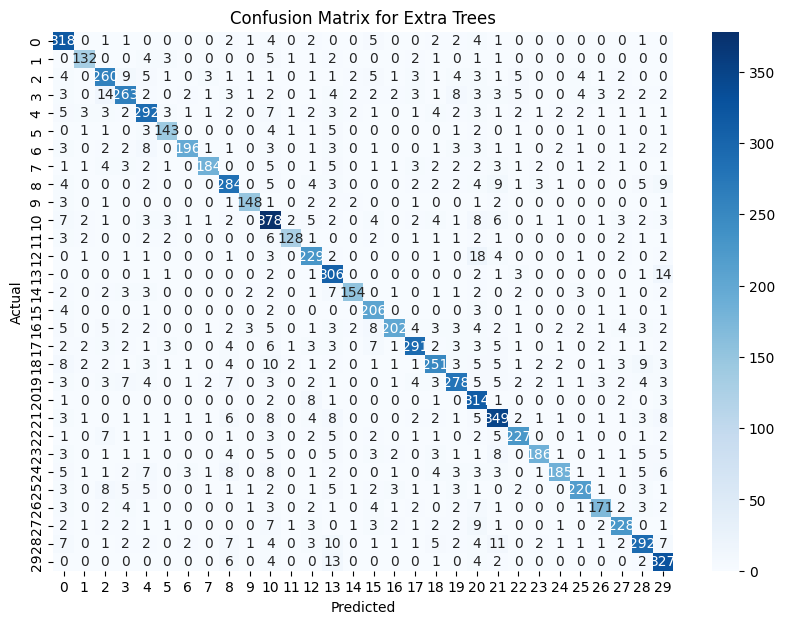


Confusion Matrix for Extra Trees:
[[396   0   1   0   2   0   4   0   1   0  14   0   1   1   0  11   0   2
    1   1   5   2   0   0   1   1   1   1   3   1]
 [  0 186   0   0   4   3   0   1   1   1   7   1   1   4   0   0   0   0
    1   1   0   1   0   0   1   0   0   1   0   1]
 [  2   1 326  12  10   0   1   1   1   4   3   0   2   1   1  10   2   3
    0  11   2   3  13   0   0   4   1   1   0   1]
 [  2   0  17 382   2   1   1   3   2   2   4   0   1   6   7   2   2   3
    2   4   4   3   6   2   1   2   6   3   2   5]
 [  3   3   1   3 375   2   2   2   3   1   7   2   2   8   1   0   0   3
    4   5   6   4   3   0   3   2   1   2   2   1]
 [  0   1   0   0   3 182   0   0   0   0   8   3   2   1   0   0   0   2
    1   0   3   0   0   0   0   0   0   1   0   3]
 [  4   0   3   1   5   0 256   1   1   0   5   0   0   2   2   3   0   1
    1   2   3   2   0   0   3   1   0   1   2   2]
 [  2   0   4   1   6   3   1 234   4   0   3   0   2   2   1   1   4   4
    1   1   0   

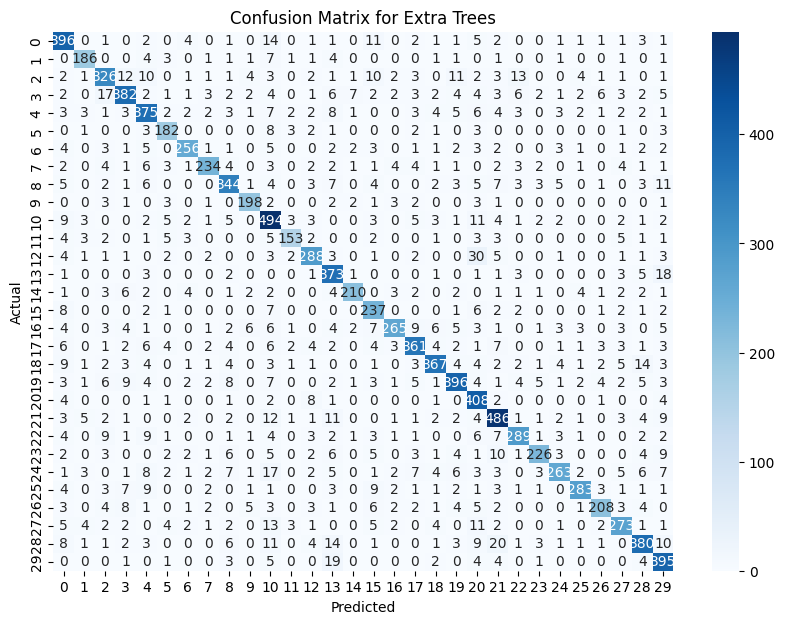

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/cooking_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=3):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


window size=10

Mounted at /content/gdrive
SVM (Linear Kernel) Average Accuracy: 0.4913
SVM (RBF Kernel) Average Accuracy: 0.5246
Random Forest Average Accuracy: 0.7299
AdaBoost Average Accuracy: 0.1291
Extra Trees Average Accuracy: 0.7431

Best performing model: Extra Trees with Average Accuracy: 0.7431

Test Accuracy of the best model (Extra Trees): 0.7670


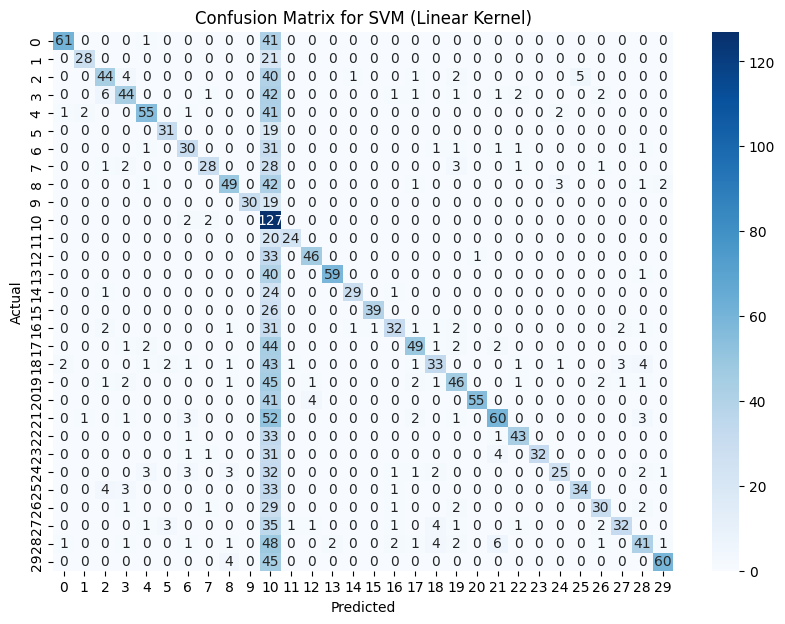

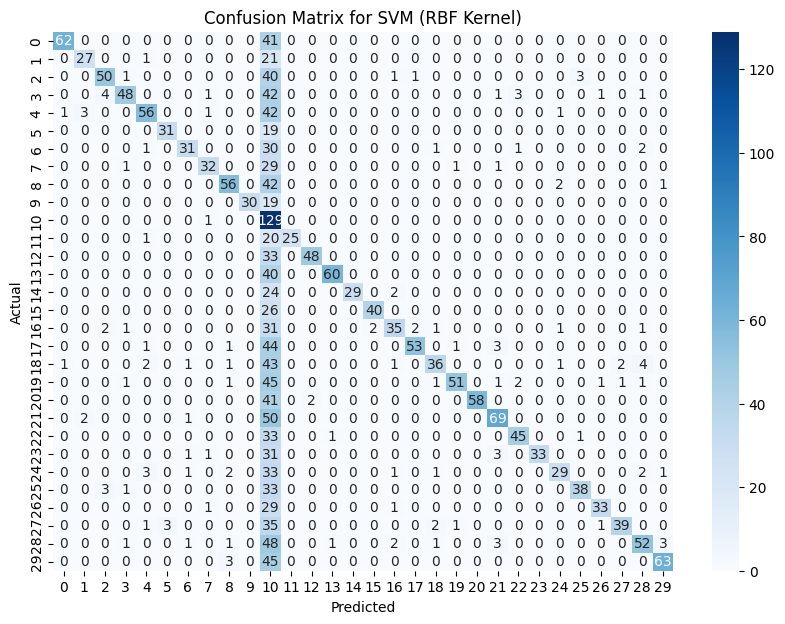

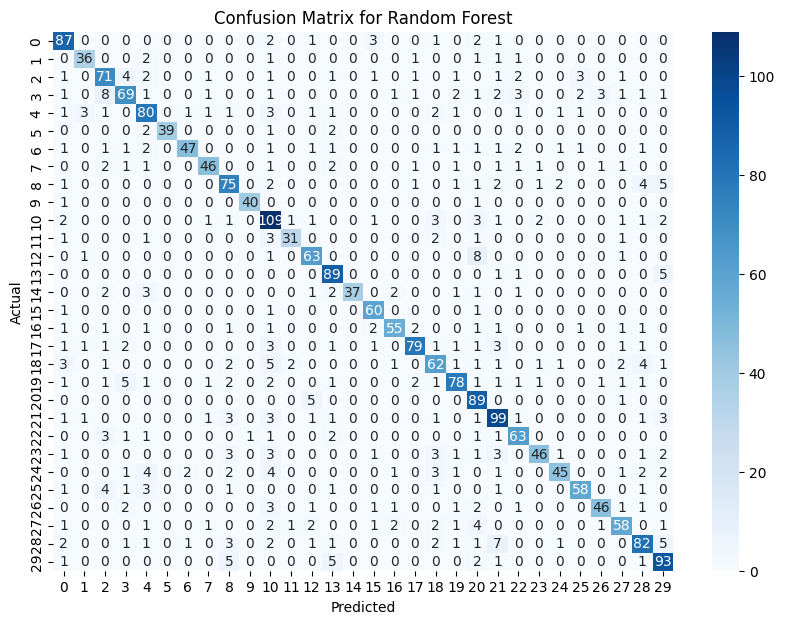

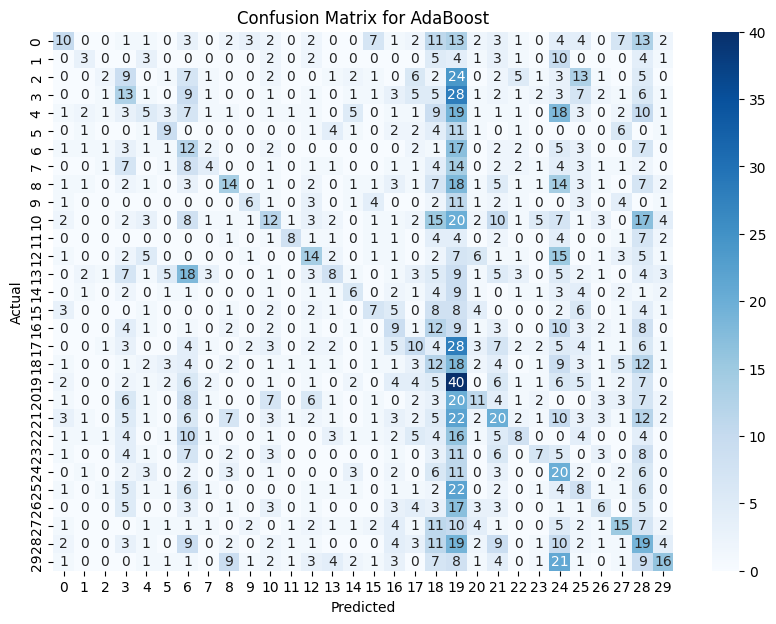

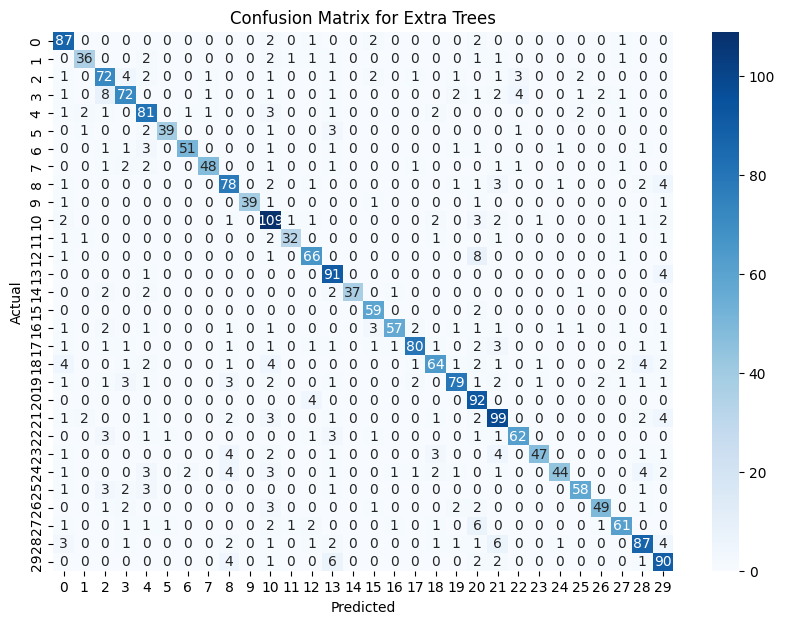


Confusion Matrix for Extra Trees:
[[125   0   0   0   3   0   0   0   0   0   1   0   1   0   0   3   0   0
    1   1   5   1   0   1   0   0   0   1   1   0]
 [  0  48   0   0   1   0   0   0   0   0   1   1   0   1   0   1   0   0
    0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0  92   3   2   1   0   3   0   0   3   0   0   1   0   1   1   0
    1   2   1   0   4   0   0   1   1   0   0   1]
 [  1   0   9  85   2   1   1   0   3   0   2   0   0   4   2   1   1   0
    2   5   1   3   0   0   0   1   4   1   1   1]
 [  1   1   2   1 104   0   2   0   0   0   3   1   1   1   0   0   0   1
    2   0   3   2   0   0   1   3   0   0   1   2]
 [  0   1   0   0   0  45   0   0   0   0   1   2   0   5   0   0   1   3
    0   0   1   0   2   0   0   0   0   0   0   1]
 [  2   0   1   1   6   0  75   0   1   0   3   1   0   2   0   0   0   0
    0   0   2   0   0   0   2   0   0   2   1   1]
 [  0   2   1   3   2   0   0  75   1   0   1   1   1   2   0   0   1   0
    2   0   1   

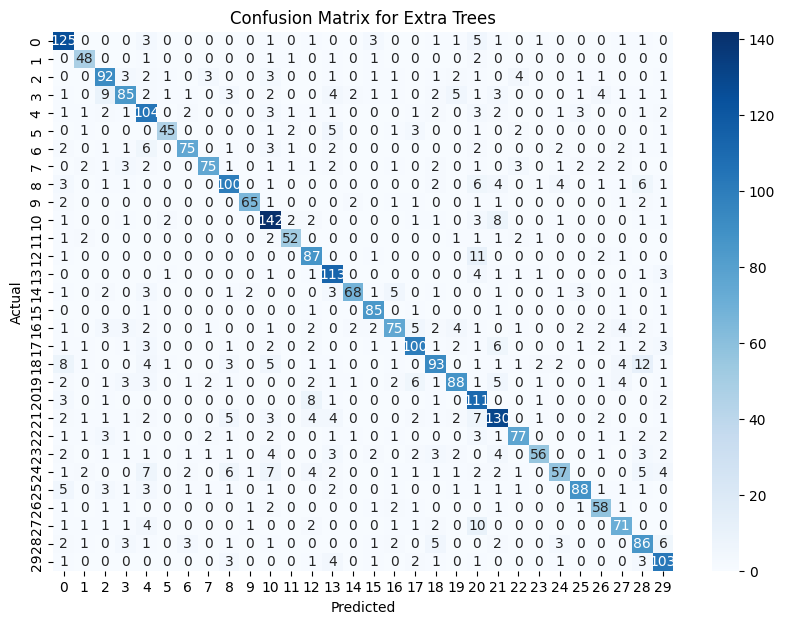

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

def load_data_with_user_id(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            user_id = filename.replace('.csv', '')  # Extract user_id from filename, stripping the .csv extension
            data['user_id'] = user_id  # Add user_id to the DataFrame
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

directory = '/content/gdrive/MyDrive/games/cooking_simulator'
data = load_data_with_user_id(directory)

def extract_window_features(data, window_size=10):
    grouped = data.groupby('user_id')  # Group data by user_id
    features_list = []

    for user_id, group in grouped:
        max_time = group['time'].max()
        step_size = window_size
        num_windows = int(np.ceil(max_time / step_size))

        for i in range(num_windows):
            start_time = i * step_size
            end_time = start_time + window_size
            window_data = group[(group['time'] >= start_time) & (group['time'] < end_time)]

            if not window_data.empty:
                numeric_data = window_data.select_dtypes(include=[np.number]).drop(['time'], axis=1)

                # Calculate mean, min, max
                feature_means = numeric_data.mean().reset_index(drop=True)
                feature_min = numeric_data.min().reset_index(drop=True)
                feature_max = numeric_data.max().reset_index(drop=True)

                # Calculate trend (slope of linear regression)
                model = LinearRegression()
                X = np.arange(len(numeric_data)).reshape(-1, 1)  # Time variable
                trends = []
                for column in numeric_data.columns:
                    y = numeric_data[column].values.reshape(-1, 1)
                    model.fit(X, y)
                    trends.append(model.coef_[0][0])  # Slope of the fit

                # Calculate average difference
                differences = numeric_data.diff().iloc[1:].mean().reset_index(drop=True)

                # Assemble the DataFrame
                features = pd.DataFrame({
                    'mean': feature_means,
                    'min': feature_min,
                    'max': feature_max,
                    'trend': trends,
                    'avg_diff': differences
                }).T  # Transpose to turn rows into columns

                features['user_id'] = user_id
                features_list.append(features)

    return pd.concat(features_list, ignore_index=True)

features_df = extract_window_features(data)

# Preparing the data for model training and evaluation
X = features_df.drop('user_id', axis=1)
y = features_df['user_id']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Define models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear'),
    'SVM (RBF Kernel)': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Setup cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
model_results = {name: [] for name in models}
model_conf_matrices = {name: [] for name in models}

# Perform cross-validation on the training set
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Scale data if necessary
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    for name, model in models.items():
        if 'SVM' in name:
            model.fit(X_train_fold_scaled, y_train_fold)
            predictions = model.predict(X_val_fold_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            predictions = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, predictions)
        model_results[name].append(accuracy)

        # Compute and store confusion matrix
        conf_matrix = confusion_matrix(y_val_fold, predictions)
        model_conf_matrices[name].append(conf_matrix)

# Calculate the average accuracy and confusion matrix for each model
average_accuracies = {name: np.mean(accuracies) for name, accuracies in model_results.items()}
average_conf_matrices = {name: np.mean(conf_matrices, axis=0) for name, conf_matrices in model_conf_matrices.items()}

# Print average accuracies for all models
for name, avg_accuracy in average_accuracies.items():
    print(f"{name} Average Accuracy: {avg_accuracy:.4f}")

# Select the best model based on average accuracy
best_model_name = max(average_accuracies, key=average_accuracies.get)
best_model = models[best_model_name]

print(f"\nBest performing model: {best_model_name} with Average Accuracy: {average_accuracies[best_model_name]:.4f}")

# Train the best model on the entire training set
if 'SVM' in best_model_name:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    best_model.fit(X_train_scaled, y_train)
    test_predictions = best_model.predict(X_test_scaled)
else:
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"\nTest Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

# Plot the confusion matrix for all models
for name, conf_matrix in average_conf_matrices.items():
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix.astype(int), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

# Calculate and display the confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, test_predictions)
print(f"\nConfusion Matrix for {best_model_name}:")
print(conf_matrix)

# Plot the confusion matrix for the best model
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


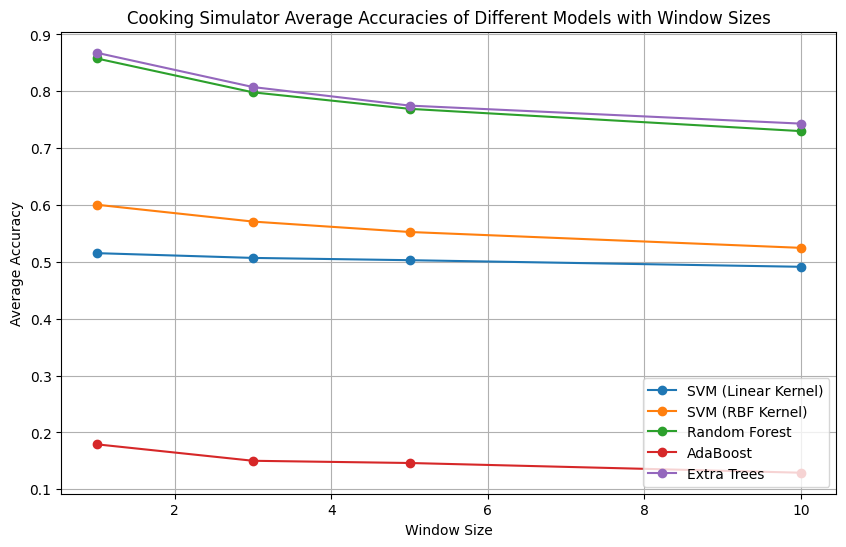

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define window sizes and average accuracies for each model
window_sizes = [1, 3, 5, 10]
svm_linear_accuracies = [0.5153, 0.5069, 0.5029, 0.4913]
svm_rbf_accuracies = [ 0.6005, 0.5708, 0.5525, 0.5246]
random_forest_accuracies = [0.8578, 0.7981, 0.7691, 0.7299]
adaboost_accuracies = [0.1791, 0.1501, 0.1462, 0.1291]
extra_trees_accuracies = [0.8678, 0.8074, 0.7748, 0.7431]

# Plotting the graph
plt.figure(figsize=(10, 6))

plt.plot(window_sizes, svm_linear_accuracies, marker='o', label='SVM (Linear Kernel)')
plt.plot(window_sizes, svm_rbf_accuracies, marker='o', label='SVM (RBF Kernel)')
plt.plot(window_sizes, random_forest_accuracies, marker='o', label='Random Forest')
plt.plot(window_sizes, adaboost_accuracies, marker='o', label='AdaBoost')
plt.plot(window_sizes, extra_trees_accuracies, marker='o', label='Extra Trees')

plt.title('Cooking Simulator Average Accuracies of Different Models with Window Sizes')
plt.xlabel('Window Size')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid(True)
plt.show()
